# Лабораторная работа № 1  
## Выполнение разведочного анализа больших данных с использованием фреймворка Apache Spark  
**Часть 2**

В данной части работы рассмотрены:

- разведочный анализ данных;
- работа с Dataframe API фреймворка Apache Spark.

In [2]:
import os
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.sql.functions import (
    col, lit, sum, mean, when,
    explode, count, desc, floor,
    corr, array_contains, first
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Сформируем объект конфигурации для Apache Spark, указав необходимые параметры.
(Адаптация — локальный режим `local[*]` и указание HDFS-сервиса в docker-compose)

In [3]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.
    Адаптировано для локального запуска в Docker (local[*]) c доступом к HDFS.
    Возвращает настроенный SparkConf.
    """
    user_name = "jovyan"
    
    conf = SparkConf()
    conf.setAppName("lab_1_part2")
    conf.setMaster("local[*]")  # локальный режим для docker-окружения
    conf.set("spark.sql.adaptive.enabled", "true")
    
    # Ресурсы — значение удобно для локального контейнера, можно подстраивать
    conf.set("spark.executor.memory", "6g")
    conf.set("spark.executor.cores", "2")
    conf.set("spark.executor.instances", "1")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "1")
    
    # Настройка для работы с HDFS внутри docker-compose
    conf.set("spark.hadoop.fs.defaultFS", "hdfs://hadoop-namenode:9820")
    conf.set("spark.hadoop.dfs.client.use.datanode.hostname", "true")
    
    # Сохраняем Iceberg-конфиги.
    conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}/warehouse")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf


Создаём объект конфигурации и сессию Apache Spark.

In [4]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию Apache Spark

In [5]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

Укажем базу данных, которая была создана в первой части лабораторной работы.

In [8]:
database_name = "gordeev_database"

Прочитаем сохранённую в предыдущей части работы таблицу и загрузим её в Spark Dataframe.

In [10]:
df = spark.table(f"spark_catalog.{database_name}.sobd_lab1_table")

Выведем прочитанную таблицу на экран.

In [11]:
df.show()

+-----------------+---------------+------------+-----+-------------+----------+------------+------+---------+--------------------+---------------+-------+-------+------------+----+
|              vin|      body_type|daysonmarket|fleet|has_accidents|horsepower|is_certified|is_cpo|is_oemcpo|       major_options|maximum_seating|mileage|  price|wheel_system|year|
+-----------------+---------------+------------+-----+-------------+----------+------------+------+---------+--------------------+---------------+-------+-------+------------+----+
|ZACNJABB5KPJ92081|SUV / Crossover|         522| NULL|         NULL|     177.0|        NULL|  NULL|     NULL|[Quick Order Pack...|              5|    7.0|23141.0|         FWD|2019|
|SALCJ2FX1LH858117|SUV / Crossover|         207| NULL|         NULL|     246.0|        NULL|  NULL|     NULL|[Adaptive Cruise ...|              7|    8.0|46500.0|         AWD|2020|
|JF1VA2M67G9829723|          Sedan|        1233|false|        false|     305.0|        NULL|  N

Посмотрим на схему данных.

In [12]:
df.printSchema()

root
 |-- vin: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- daysonmarket: integer (nullable = true)
 |-- fleet: boolean (nullable = true)
 |-- has_accidents: boolean (nullable = true)
 |-- horsepower: float (nullable = true)
 |-- is_certified: boolean (nullable = true)
 |-- is_cpo: boolean (nullable = true)
 |-- is_oemcpo: boolean (nullable = true)
 |-- major_options: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- maximum_seating: integer (nullable = true)
 |-- mileage: float (nullable = true)
 |-- price: float (nullable = true)
 |-- wheel_system: string (nullable = true)
 |-- year: integer (nullable = true)



Вычислим количество строк в датафрейме.

In [13]:
df.count()

1000367

## Анализ столбца vin

Отсортируем датафрейм по столбцу vin, который может рассматриваться в качестве первичного ключа таблицы.

In [15]:
df.orderBy("vin", ascending=False).show()

+--------------------+---------------+------------+-----+-------------+----------+------------+------+---------+--------------------+---------------+-------+--------+--------------------+----+
|                 vin|      body_type|daysonmarket|fleet|has_accidents|horsepower|is_certified|is_cpo|is_oemcpo|       major_options|maximum_seating|mileage|   price|        wheel_system|year|
+--------------------+---------------+------------+-----+-------------+----------+------------+------+---------+--------------------+---------------+-------+--------+--------------------+----+
|Zero Modification...|           NULL|        NULL| NULL|         NULL|      NULL|        NULL|  NULL|     NULL|                NULL|           NULL|   NULL|    NULL|                NULL|NULL|
|   ZPBUA1ZLXKLA00955|SUV / Crossover|         649|false|        false|     641.0|        NULL|  NULL|     NULL|                NULL|              5|  480.0|285000.0|                 AWD|2019|
|   ZPBUA1ZL8KLA04082|SUV / Crossov

Видно, что некоторые значения ключа довольно странные (представляют собой больше описание, чем ключ). Удалим из датафрейма строки с такими ключами, оставив только подходящие по шаблону.

In [16]:
# Регулярное выражение для VIN длиной 17 символов, состоящих из цифр и букв
vin_pattern = r"^[A-Z0-9]{17}$"

# Фильтрация DataFrame
df = df.filter(col("vin").rlike(vin_pattern))
df.show()

+-----------------+---------------+------------+-----+-------------+----------+------------+------+---------+--------------------+---------------+-------+-------+------------+----+
|              vin|      body_type|daysonmarket|fleet|has_accidents|horsepower|is_certified|is_cpo|is_oemcpo|       major_options|maximum_seating|mileage|  price|wheel_system|year|
+-----------------+---------------+------------+-----+-------------+----------+------------+------+---------+--------------------+---------------+-------+-------+------------+----+
|ZACNJABB5KPJ92081|SUV / Crossover|         522| NULL|         NULL|     177.0|        NULL|  NULL|     NULL|[Quick Order Pack...|              5|    7.0|23141.0|         FWD|2019|
|SALCJ2FX1LH858117|SUV / Crossover|         207| NULL|         NULL|     246.0|        NULL|  NULL|     NULL|[Adaptive Cruise ...|              7|    8.0|46500.0|         AWD|2020|
|JF1VA2M67G9829723|          Sedan|        1233|false|        false|     305.0|        NULL|  N

In [17]:
df.count()

999143

Проверим наличие дубликатов в датафрейме.

In [18]:
(
    df
    .groupBy("vin")
    .count()
    .where("count > 1")
    .orderBy("count", ascending=False)
    .show()
)

+---+-----+
|vin|count|
+---+-----+
+---+-----+



In [19]:
df.filter(col("vin") == "1G1ZE5SX2LF145812").show()

+---+---------+------------+-----+-------------+----------+------------+------+---------+-------------+---------------+-------+-----+------------+----+
|vin|body_type|daysonmarket|fleet|has_accidents|horsepower|is_certified|is_cpo|is_oemcpo|major_options|maximum_seating|mileage|price|wheel_system|year|
+---+---------+------------+-----+-------------+----------+------------+------+---------+-------------+---------------+-------+-----+------------+----+
+---+---------+------------+-----+-------------+----------+------------+------+---------+-------------+---------------+-------+-----+------------+----+



Похоже на полную идентичность строк. Удалим дубликаты.

In [20]:
df = df.dropDuplicates(["vin"])
df.count()

999143

In [21]:
df.show()

+-----------------+------------+------------+-----+-------------+----------+------------+------+---------+--------------------+---------------+------------+--------+------------+----+
|              vin|   body_type|daysonmarket|fleet|has_accidents|horsepower|is_certified|is_cpo|is_oemcpo|       major_options|maximum_seating|     mileage|   price|wheel_system|year|
+-----------------+------------+------------+-----+-------------+----------+------------+------+---------+--------------------+---------------+------------+--------+------------+----+
|00000000012870842|       Coupe|         210|false|        false|      NULL|        NULL|  NULL|     NULL|                NULL|           NULL|        NULL|105500.0|        NULL|1968|
|00000000020179562|       Coupe|          56|false|        false|      NULL|        NULL|  NULL|     NULL|[Alloy Wheels, Ba...|           NULL|        NULL|159900.0|        NULL|2017|
|00000000076526377|       Sedan|         111|false|        false|      NULL|    

## Анализ столбца body_type

Посмотрим внимательно на значения в столбце. Видно, что в данном столбце расположен категориальный признак.

Введем функцию, определяющую количество NULL-значений в столбце.

In [22]:
def count_nulls(data: DataFrame,
                column_name: str) -> None:
    """
    Подсчет количества null и not null значений в указанном столбце.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для подсчета null и not null значений.
    
    Returns:
        None
    """
    # Подсчет количества null значений в указанном столбце
    null_counts = data.select(
        sum(col(column_name).isNull().cast("int"))
    ).collect()[0][0]

    # Подсчет количества not null значений в указанном столбце
    not_null_counts = data.select(
        sum(col(column_name).isNotNull().cast("int"))
    ).collect()[0][0]

    # Вывод результатов
    print(f"Число колонок с NULL: {null_counts} "
          f"({100 * null_counts / (null_counts + not_null_counts):.2f}%)")

In [23]:
count_nulls(data=df, column_name="body_type")

Число колонок с NULL: 4269 (0.43%)


Видно, что столбец body_type содержит небольшое количество пропущенных значений. Поскольку признак содержит категорию (тип кузова автомобиля), то логично заменить пропущенные значения на категорию Unknown.

In [24]:
df = df.fillna({"body_type": "Unknown"})
count_nulls(data=df, column_name="body_type")

Число колонок с NULL: 0 (0.00%)


Создадим функцию расчета и визуализации распределения категориальных признаков.

In [26]:
def plot_cat_distribution(data: DataFrame,
                          column_name: str,
                          top_n: int = 20) -> None:
    """
    Построение распределения категориального признака.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для группировки.
        top_n (int): Количество топ-значений для отображения.
    
    Returns:
        None
    """
    # Группировка данных по столбцу и подсчет количества
    categories = (
        data
        .groupBy(column_name)
        .count()
        .orderBy("count", ascending=False)
    )
    
    print(f"Количество категорий признака {column_name}: {categories.count()}")

    categories = (
        categories
        .limit(top_n)
        .toPandas()
    )
    
    # Визуализация с использованием Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column_name, y="count", data=categories)
    plt.title(f"Barplot of \"{column_name}\" counts")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

Количество категорий признака body_type: 10


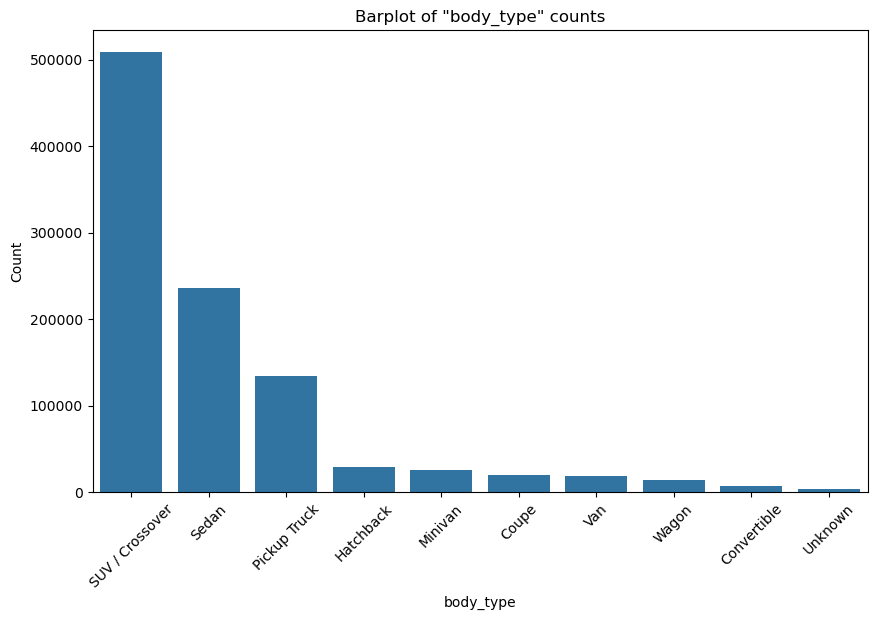

In [27]:
plot_cat_distribution(data=df, column_name="body_type")

Видно, что автомобили в представленном датасете имеют 9 определенных типов кузова, а для части автомобилей тип кузова неизвестен.

## Анализ столбца daysonmarket

В соответствии с описанием и содержанием датасета логично считать данный признак количественным. Проверим его на наличие пропущенных значений.

In [28]:
count_nulls(data=df, column_name="daysonmarket")

Число колонок с NULL: 0 (0.00%)


Видно, что пропуски в данном столбце отсутствуют.

Создадим функцию, позволяющую рассчитывать статистические показатели данных в столбцах и строить диаграмму "ящик с усами" для оценки наличия выбросов.

In [29]:
def plot_boxplots(data: DataFrame,
                  columns: list[str],
                  sample_fraction: float = 0.1) -> None:
    """
    Построение boxplot для нескольких столбцов в PySpark DataFrame.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        columns (list of str): Список имен столбцов для построения boxplot.
        sample_fraction (float): Доля данных для семплирования выбросов.
    
    Returns:
        None
    """
    box_data = []

    for column in columns:
        # Вычисление квантилей
        quantiles = data.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
        q1, median, q3 = quantiles

        # Вычисление IQR и границ усов
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Фильтрация выбросов
        filtered_df = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
        outliers_df = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))

        # Вычисление минимального и максимального значений
        min_value = data.agg({column: "min"}).collect()[0][0]
        mean_value = data.agg({column: "mean"}).collect()[0][0]
        std_value = data.agg({column: "std"}).collect()[0][0]
        max_value = data.agg({column: "max"}).collect()[0][0]

        # Ограничение усов минимальным и максимальным значениями
        lower_bound = max(lower_bound, min_value)
        upper_bound = min(upper_bound, max_value)

        # Семплирование выбросов
        outliers = []
        if not outliers_df.isEmpty():
            sampled_outliers_df = outliers_df.sample(sample_fraction)
            outliers = (
                sampled_outliers_df
                .select(column)
                .limit(1000)
                .collect()
            )
            outliers = [row[column] for row in outliers]
            
            # Добавление минимального и максимального значений, если они 
            # относятся к выбросам и не присутствуют в семпле
            if min_value < lower_bound and min_value not in outliers:
                outliers.append(min_value)
            if max_value > upper_bound and max_value not in outliers:
                outliers.append(max_value)

        # Подготовка данных для axes.bxp
        box_data.append({
            'whislo': lower_bound,  # Нижняя граница усов
            'q1': q1,               # Первый квартиль
            'med': median,          # Медиана
            'q3': q3,               # Третий квартиль
            'whishi': upper_bound,  # Верхняя граница усов
            'fliers': outliers      # Выбросы
        })
        
    # Вывод статистических характеристик
    print(f"Минимальное значение:          {min_value:.2f}")
    print(f"Среднее значение:              {mean_value:.2f}")
    print(f"Среднеквадратичное отклонение: {std_value:.2f}")
    print(f"Первый квартиль:               {q1:.2f}")
    print(f"Медиана:                       {median:.2f}")
    print(f"Третий квартиль:               {q3:.2f}")
    print(f"Максимальное значение:         {max_value:.2f}")

    # Построение boxplot
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.bxp(box_data, 
           vert=False, 
           positions=range(1, len(columns) + 1), widths=0.5)
    ax.set_yticks(range(1, len(columns) + 1))
    ax.set_yticklabels(columns)
    ax.set_xlabel('Value')
    ax.set_title('Boxplots')
    ax.grid(True)
    plt.show()

Минимальное значение:          0.00
Среднее значение:              77.78
Среднеквадратичное отклонение: 109.81
Первый квартиль:               14.00
Медиана:                       35.00
Третий квартиль:               83.00
Максимальное значение:         3573.00


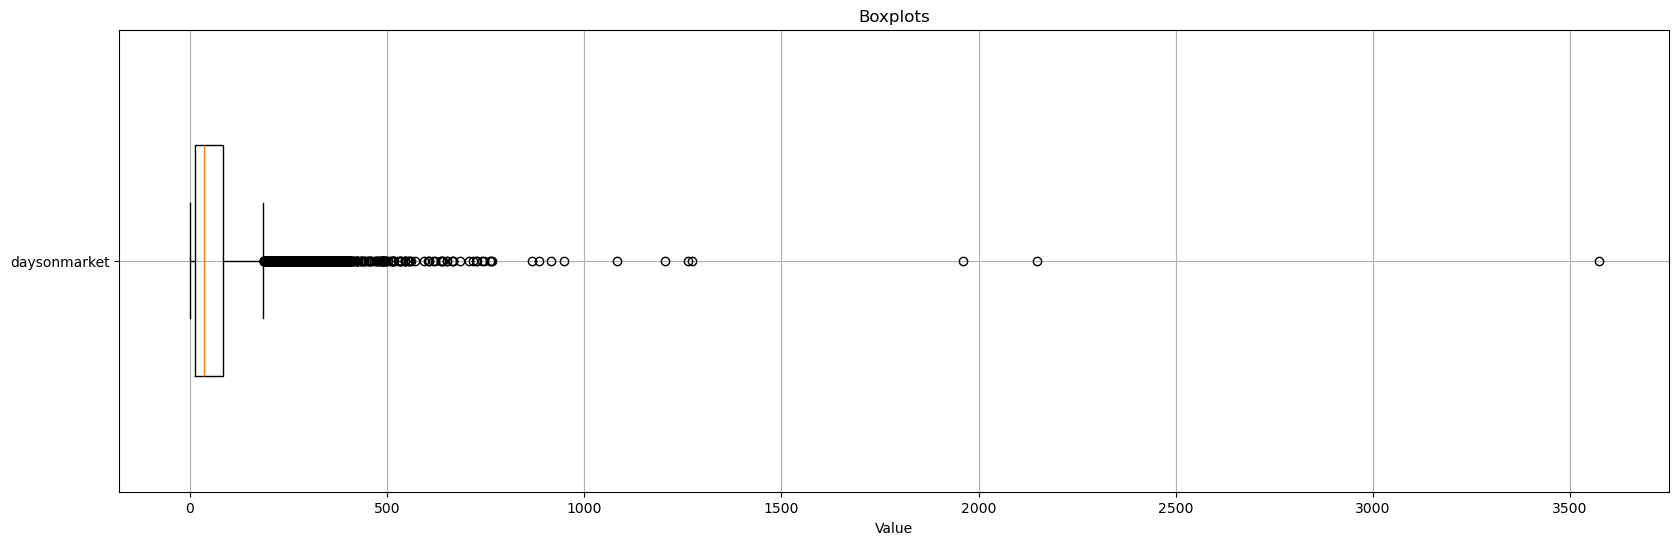

In [30]:
plot_boxplots(data=df, columns=["daysonmarket"])

Наблюдаем значительное количество выбросов в данных. Для более тщательного исследования создадим функцию для визуализации распределения категориального признака.

In [31]:
def plot_quant_distribution(data: DataFrame,
                            column: str,
                            num_bins: int = 200) -> None:
    """
    Построение гистограммы для количественной переменной с 
    использованием PySpark и Seaborn.

    Args:
        data (DataFrame): DataFrame с данными.
        column_name (str): Название колонки с количественной переменной.
        num_bins (int): Количество бинов для гистограммы.

    Returns:
        None
    """
    # Находим минимальное и максимальное значения колонки
    min_value = data.agg({column: "min"}).collect()[0][0]
    max_value = data.agg({column: "max"}).collect()[0][0]

    # Размер бина
    bin_size = (max_value - min_value) / num_bins

    # Добавляем колонку с номером бина
    data = data.withColumn(
        "bin", 
        floor((col(column) - min_value) / bin_size)
    )

    # Группируем по номеру бина и считаем количество строк в каждом бине
    bin_counts = data.groupBy("bin").count()

    # Преобразуем результат в Pandas DataFrame для построения гистограммы
    bin_counts_pd = bin_counts.limit(1000).toPandas()
    
    # Создаем массив границ бинов
    bin_edges = [min_value + i * bin_size for i in range(num_bins + 2)]
    
    # Преобразуем номера бинов в центры бинов
    bin_centers = [
        (bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins + 1)
    ]
    
    # Добавляем центры бинов в Pandas DataFrame
    bin_counts_pd['bin_center'] = bin_counts_pd['bin'].apply(
        lambda x: bin_centers[int(x)]
    )
    
    # Построение гистограммы с использованием Seaborn
    plt.figure(figsize=(20, 6))
    sns.histplot(data=bin_counts_pd, x="bin_center", 
                 weights="count", kde=True, bins=num_bins + 1)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.title(f"Распределение количественного признака \"{column}\"")
    plt.grid(True)
    plt.show()

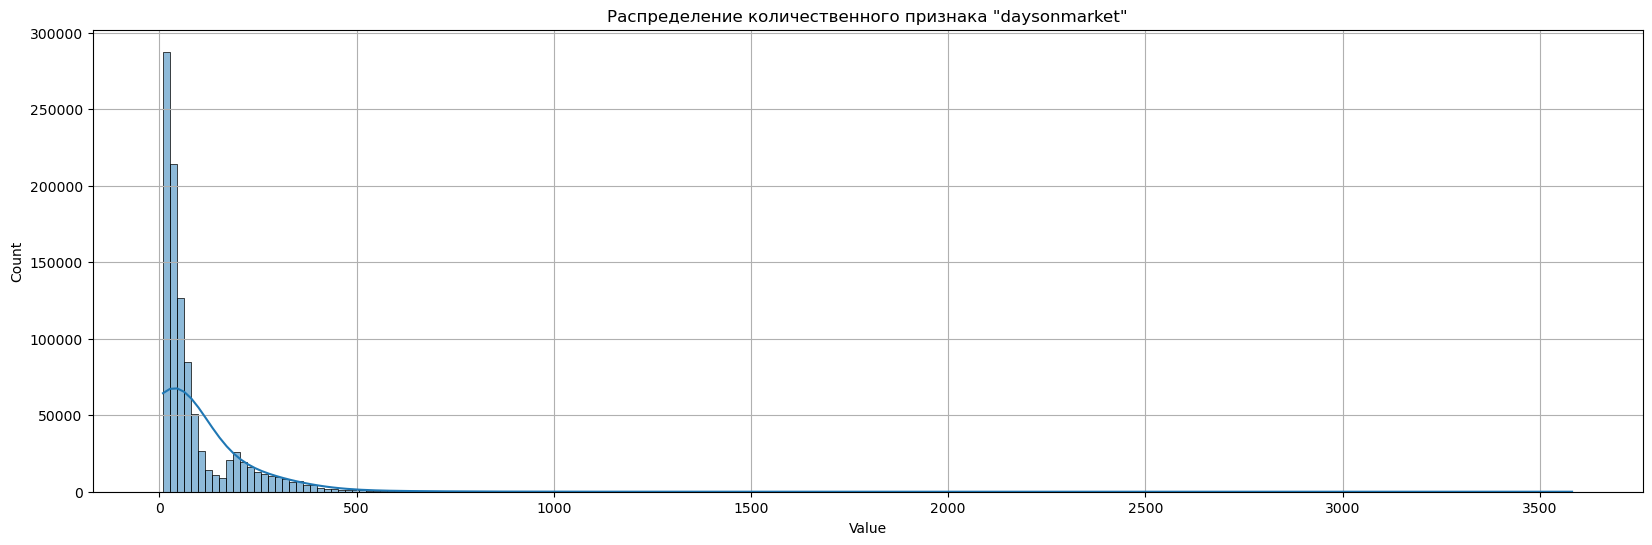

In [32]:
plot_quant_distribution(data=df, column="daysonmarket")

In [33]:
df = df.withColumn(
    "daysonmarket",
    when(col("daysonmarket") > 500.0, 500.0)
        .otherwise(col("daysonmarket"))
)

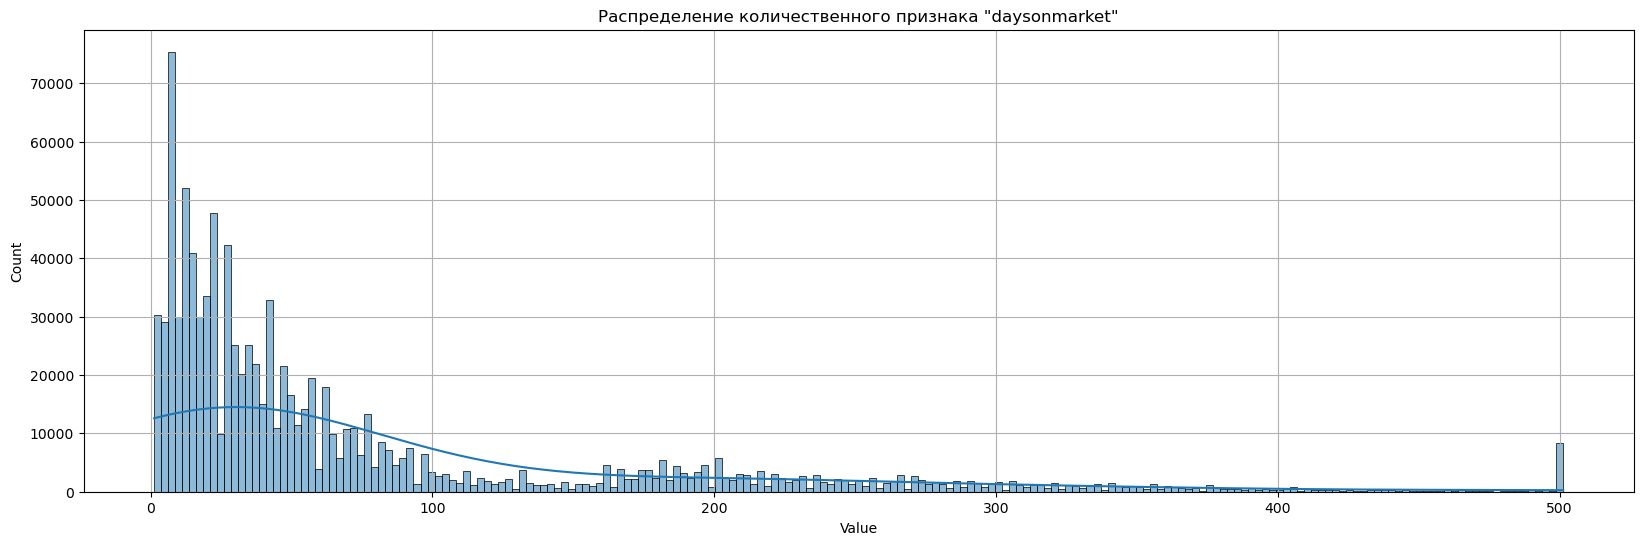

In [34]:
plot_quant_distribution(data=df, column="daysonmarket")

In [35]:
df.show()

+-----------------+------------+------------+-----+-------------+----------+------------+------+---------+--------------------+---------------+------------+--------+------------+----+
|              vin|   body_type|daysonmarket|fleet|has_accidents|horsepower|is_certified|is_cpo|is_oemcpo|       major_options|maximum_seating|     mileage|   price|wheel_system|year|
+-----------------+------------+------------+-----+-------------+----------+------------+------+---------+--------------------+---------------+------------+--------+------------+----+
|00000000012870842|       Coupe|       210.0|false|        false|      NULL|        NULL|  NULL|     NULL|                NULL|           NULL|        NULL|105500.0|        NULL|1968|
|00000000020179562|       Coupe|        56.0|false|        false|      NULL|        NULL|  NULL|     NULL|[Alloy Wheels, Ba...|           NULL|        NULL|159900.0|        NULL|2017|
|00000000076526377|       Sedan|       111.0|false|        false|      NULL|    

## Анализ столбца fleet

In [36]:
count_nulls(data=df, column_name="fleet")

Число колонок с NULL: 650720 (65.13%)


Видно, что более половины данных в столбце пропущены. Можно, конечно, попытаться обработать то, что есть, но в целях упрощения анализа просто удалим столбец.

In [37]:
df = df.drop("fleet")
df.show()

+-----------------+------------+------------+-------------+----------+------------+------+---------+--------------------+---------------+------------+--------+------------+----+
|              vin|   body_type|daysonmarket|has_accidents|horsepower|is_certified|is_cpo|is_oemcpo|       major_options|maximum_seating|     mileage|   price|wheel_system|year|
+-----------------+------------+------------+-------------+----------+------------+------+---------+--------------------+---------------+------------+--------+------------+----+
|00000000012870842|       Coupe|       210.0|        false|      NULL|        NULL|  NULL|     NULL|                NULL|           NULL|        NULL|105500.0|        NULL|1968|
|00000000020179562|       Coupe|        56.0|        false|      NULL|        NULL|  NULL|     NULL|[Alloy Wheels, Ba...|           NULL|        NULL|159900.0|        NULL|2017|
|00000000076526377|       Sedan|       111.0|        false|      NULL|        NULL|  NULL|     NULL|          

## Анализ столбца has_accidents

In [38]:
count_nulls(data=df, column_name="has_accidents")

Число колонок с NULL: 638182 (63.87%)


Как видим, ситуация аналогичная. Удаляем столбец.

In [ ]:
df = df.drop("has_accidents")
df.show()

## Анализ столбца horsepower

Данный столбец, согласно описанию и значениям, которые он принимает, можно отнести к количественным.

Выполним аналогичные шаги.

In [40]:
count_nulls(data=df, column_name="horsepower")

Число колонок с NULL: 417037 (41.74%)


Пропущено много значений, но меньше половины. Стоит попытаться сохранить признак и обработать его.

Минимальное значение:          0.00
Среднее значение:              250.82
Среднеквадратичное отклонение: 1463.10
Первый квартиль:               172.00
Медиана:                       208.00
Третий квартиль:               288.00
Максимальное значение:         439929.00


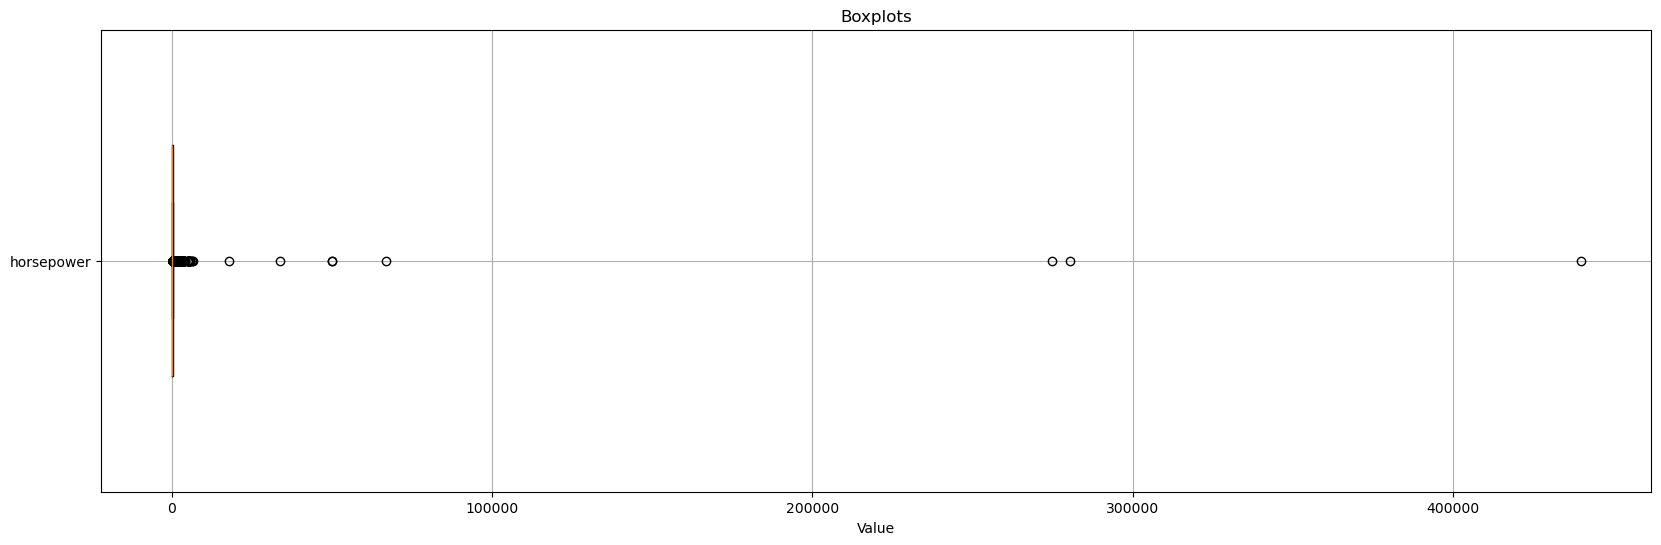

In [41]:
plot_boxplots(data=df, columns=["horsepower"])

Можно наблюдать сильные выбросы. Удалим строки, их содержащие, и убедимся, что потеряна небольшая часть данных.

In [42]:
df.filter(col("horsepower") > 400).count()

22187

Заменим пропуски средним значением признака.

In [43]:
df = df.filter(col("horsepower") < 400)
mean_horsepower = df.select(mean(col("horsepower"))).collect()[0][0]
mean_horsepower

225.02765508122965

In [44]:
df = df.fillna({"horsepower": mean_horsepower})

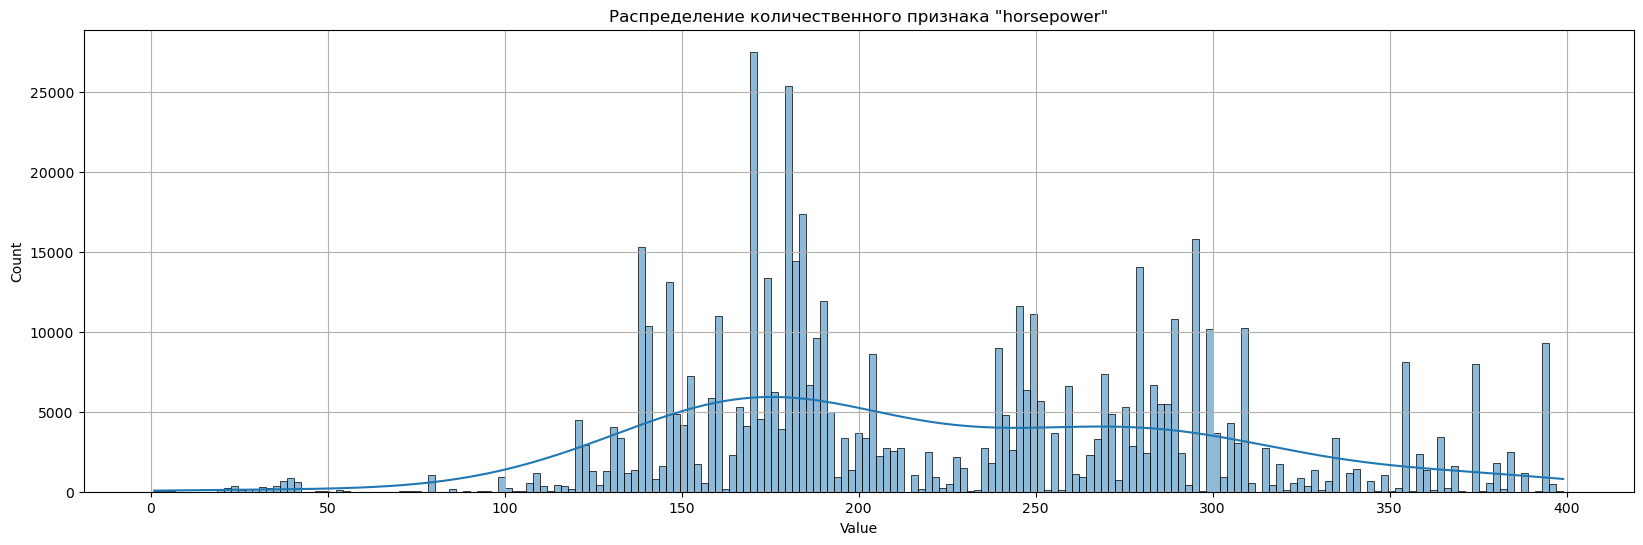

In [45]:
plot_quant_distribution(data=df, column="horsepower")

In [46]:
df.show()

+-----------------+---------+------------+----------+------------+------+---------+--------------------+---------------+-------+-------+------------+----+
|              vin|body_type|daysonmarket|horsepower|is_certified|is_cpo|is_oemcpo|       major_options|maximum_seating|mileage|  price|wheel_system|year|
+-----------------+---------+------------+----------+------------+------+---------+--------------------+---------------+-------+-------+------------+----+
|0N0RDER1111111216|    Sedan|         7.0|     252.0|        NULL|  NULL|     NULL|                NULL|              5|   NULL|32465.0|         FWD|2020|
|19UDE2F30LA011015|    Sedan|         8.0|     201.0|        NULL|  NULL|     NULL|[Sunroof/Moonroof...|              5|   11.0|26925.0|         FWD|2020|
|19UDE2F31HA005487|    Sedan|       302.0|     201.0|        NULL|  NULL|     NULL|[Leather Seats, S...|              5|39195.0|13900.0|         FWD|2017|
|19UDE2F31HA014030|    Sedan|        30.0|     201.0|        NULL|  NU

## Анализ столбцов is_certified, is_cpo, is_oemcpo

Данные признаки являются бинарными и имеют схожую интерпретацию. Заменим их одним признаком, который принимает значение True, если хотя бы один из вышеупомянитых признаков содержит истинное значение.

In [47]:
df = df.withColumn(
    "is_any_cert", 
    when(
        col("is_certified") | col("is_cpo") | col("is_oemcpo"), 
        True
    ).otherwise(False)
).drop(col("is_certified")).drop(col("is_cpo")).drop(col("is_oemcpo"))

In [48]:
df.show()

+-----------------+---------+------------+----------+--------------------+---------------+-------+-------+------------+----+-----------+
|              vin|body_type|daysonmarket|horsepower|       major_options|maximum_seating|mileage|  price|wheel_system|year|is_any_cert|
+-----------------+---------+------------+----------+--------------------+---------------+-------+-------+------------+----+-----------+
|0N0RDER1111111216|    Sedan|         7.0|     252.0|                NULL|              5|   NULL|32465.0|         FWD|2020|      false|
|19UDE2F30LA011015|    Sedan|         8.0|     201.0|[Sunroof/Moonroof...|              5|   11.0|26925.0|         FWD|2020|      false|
|19UDE2F31HA005487|    Sedan|       302.0|     201.0|[Leather Seats, S...|              5|39195.0|13900.0|         FWD|2017|      false|
|19UDE2F31HA014030|    Sedan|        30.0|     201.0|[Sunroof/Moonroof...|              5|17099.0|19975.0|         FWD|2017|      false|
|19UDE2F31LA009483|    Sedan|        28.0

In [49]:
count_nulls(data=df, column_name="is_any_cert")

Число колонок с NULL: 0 (0.00%)


Пропуски отсутствуют.

Количество категорий признака is_any_cert: 2


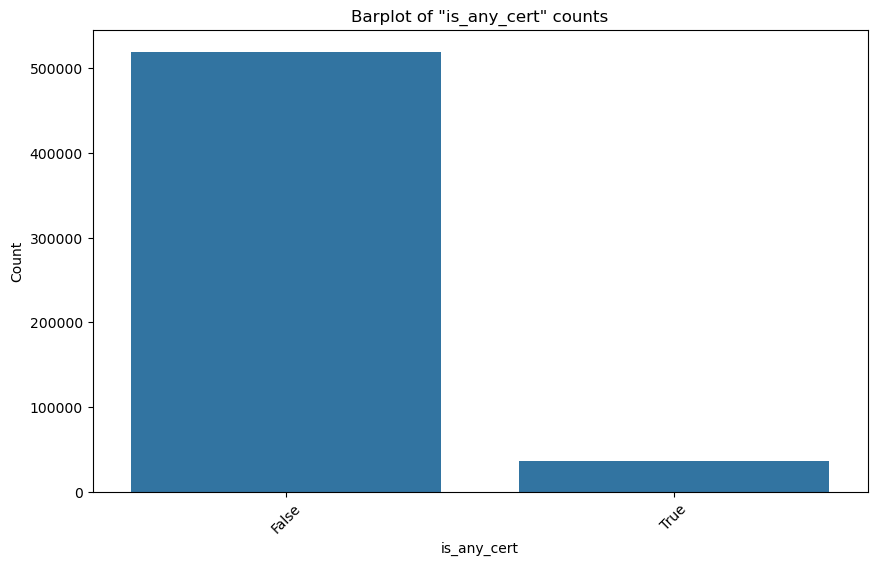

In [50]:
plot_cat_distribution(data=df, column_name="is_any_cert")

## Анализ признака major_options

In [51]:
count_nulls(data=df, column_name="major_options")

Число колонок с NULL: 48223 (8.68%)


Пропуски есть, но их немного. Заменим их пустыми списками.

In [52]:
df = df.withColumn(
    "major_options", 
    when(
        col("major_options").isNull(), 
        lit([])
    ).otherwise(col("major_options"))
)

count_nulls(data=df, column_name="major_options")

Число колонок с NULL: 0 (0.00%)


Данный признак представляет собой массив признаков. Обработаем его следующим образом. Определим пятёрку самых часто встречающихся элементов списка для всех объектов из датасета и введем пять бинарных признаков, показывающих присутствие элемента в списке конкретного объекта.

In [53]:
def get_popular_options(data: DataFrame, 
                        column: str, 
                        top_n: int = 5) -> DataFrame:
    """
    Получение DataFrame всех элементов массива опций, подсчет их количества, 
    сортировка по убыванию и вывод нескольких самых популярных элементов.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column (str): Имя столбца с массивом.
        top_n (int): Количество самых популярных элементов для вывода.

    Returns:
        DataFrame: DataFrame с самыми популярными элементами.
    """
    # Развертывание массива в отдельные строки
    exploded_df = data.withColumn("element", explode(col(column)))

    # Подсчет количества каждого элемента
    element_counts = (
        exploded_df
        .groupBy("element")
        .agg(count("element").alias("count"))
    )

    # Сортировка элементов по убыванию
    sorted_elements = element_counts.orderBy(desc("count"))

    # Вывод нескольких самых популярных элементов
    top_elements = sorted_elements.limit(top_n)

    return top_elements

Получим датафрейм из пяти самых популярных опций.

In [54]:
popular_options = get_popular_options(data=df, column="major_options")
popular_options.show()

+----------------+------+
|         element| count|
+----------------+------+
|   Backup Camera|366722|
|       Bluetooth|345992|
|    Alloy Wheels|341653|
|    Heated Seats|205319|
|Sunroof/Moonroof|185068|
+----------------+------+



In [55]:
def add_options_columns(data: DataFrame,
                        column: str,
                        popular_options: DataFrame) -> DataFrame:
    """
    Добавление новых булевых колонок в DataFrame, указывающих, 
    содержится ли определённый элемент в каждой строке.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column (str): Имя столбца с массивом.
        popular_elements (DataFrame): DataFrame с популярными элементами.

    Returns:
        DataFrame: DataFrame с новыми булевыми колонками.
    """
    # Добавление булевых колонок для каждой популярной категории
    categories_df = popular_options.select(col("element").alias("category"))
    result = data.crossJoin(categories_df.hint("broadcast"))
    result = result.withColumn("contains", 
                               array_contains(col(column), col("category")))
    result = result.groupBy(data.columns).pivot("category").agg(first("contains"))
    
    for col_name in result.columns:
        if col_name not in data.columns:
            result = result.withColumnRenamed(col_name, f"contains_{col_name}")
    
    return result

Выполним вышеописанное преобразование над датасетом, а признак-массив удалим.

In [56]:
df = add_options_columns(data=df, column="major_options", 
                         popular_options=popular_options)
df = df.drop("major_options").cache()
df.show()

+-----------------+---------+------------+----------+---------------+-------+-------+------------+----+-----------+---------------------+----------------------+------------------+---------------------+-------------------------+
|              vin|body_type|daysonmarket|horsepower|maximum_seating|mileage|  price|wheel_system|year|is_any_cert|contains_Alloy Wheels|contains_Backup Camera|contains_Bluetooth|contains_Heated Seats|contains_Sunroof/Moonroof|
+-----------------+---------+------------+----------+---------------+-------+-------+------------+----+-----------+---------------------+----------------------+------------------+---------------------+-------------------------+
|0N0RDER1111111216|    Sedan|         7.0|     252.0|              5|   NULL|32465.0|         FWD|2020|      false|                false|                 false|             false|                false|                    false|
|19UDE2F30LA011015|    Sedan|         8.0|     201.0|              5|   11.0|26925.0|   

## Анализ столбца maximum_seating

In [ ]:
Данный признак является количественным.

In [57]:
count_nulls(data=df, column_name="maximum_seating")

Число колонок с NULL: 5838 (1.05%)


In [58]:
(
    df
    .filter(col("maximum_seating").isNotNull())
    .groupBy("maximum_seating")
    .count()
    .show()
)

+---------------+------+
|maximum_seating| count|
+---------------+------+
|             12|   413|
|              6| 33511|
|              3|  5059|
|              5|397183|
|             15|  1244|
|              9|   583|
|              4| 12328|
|              8| 33287|
|              7| 58923|
|             10|   134|
|              2|  7052|
+---------------+------+



Оставим только те автомобили, число мест в которых менее 20. Их преобладающее количество.

In [59]:
df = df.filter(col("maximum_seating") < 20)
mean_maximum_seating = int(
    df.select(mean(col("maximum_seating"))).collect()[0][0]
)
mean_maximum_seating

5

In [60]:
df = df.fillna({"maximum_seating": mean_maximum_seating})

Количество категорий признака maximum_seating: 11


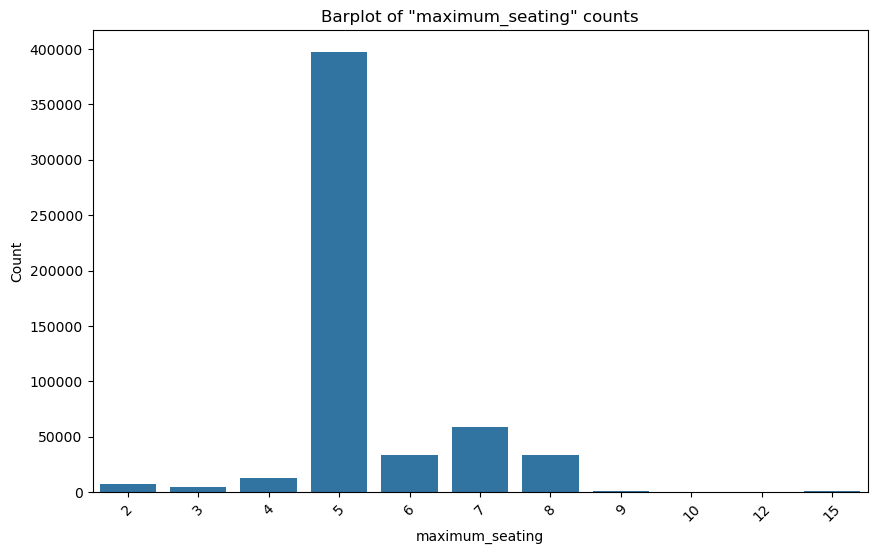

In [61]:
plot_cat_distribution(data=df, column_name="maximum_seating")

In [62]:
df.show()

+-----------------+---------+------------+----------+---------------+-------+-------+------------+----+-----------+---------------------+----------------------+------------------+---------------------+-------------------------+
|              vin|body_type|daysonmarket|horsepower|maximum_seating|mileage|  price|wheel_system|year|is_any_cert|contains_Alloy Wheels|contains_Backup Camera|contains_Bluetooth|contains_Heated Seats|contains_Sunroof/Moonroof|
+-----------------+---------+------------+----------+---------------+-------+-------+------------+----+-----------+---------------------+----------------------+------------------+---------------------+-------------------------+
|0N0RDER1111111216|    Sedan|         7.0|     252.0|              5|   NULL|32465.0|         FWD|2020|      false|                false|                 false|             false|                false|                    false|
|19UDE2F30LA011015|    Sedan|         8.0|     201.0|              5|   11.0|26925.0|   

## Анализ признака price

Признак количественный. Все преобразования аналогичны вышерассмотренным.

In [63]:
count_nulls(data=df, column_name="price")

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          299.00
Среднее значение:              25822.84
Среднеквадратичное отклонение: 14244.61
Первый квартиль:               15995.00
Медиана:                       24233.00
Третий квартиль:               32770.00
Максимальное значение:         2698500.00


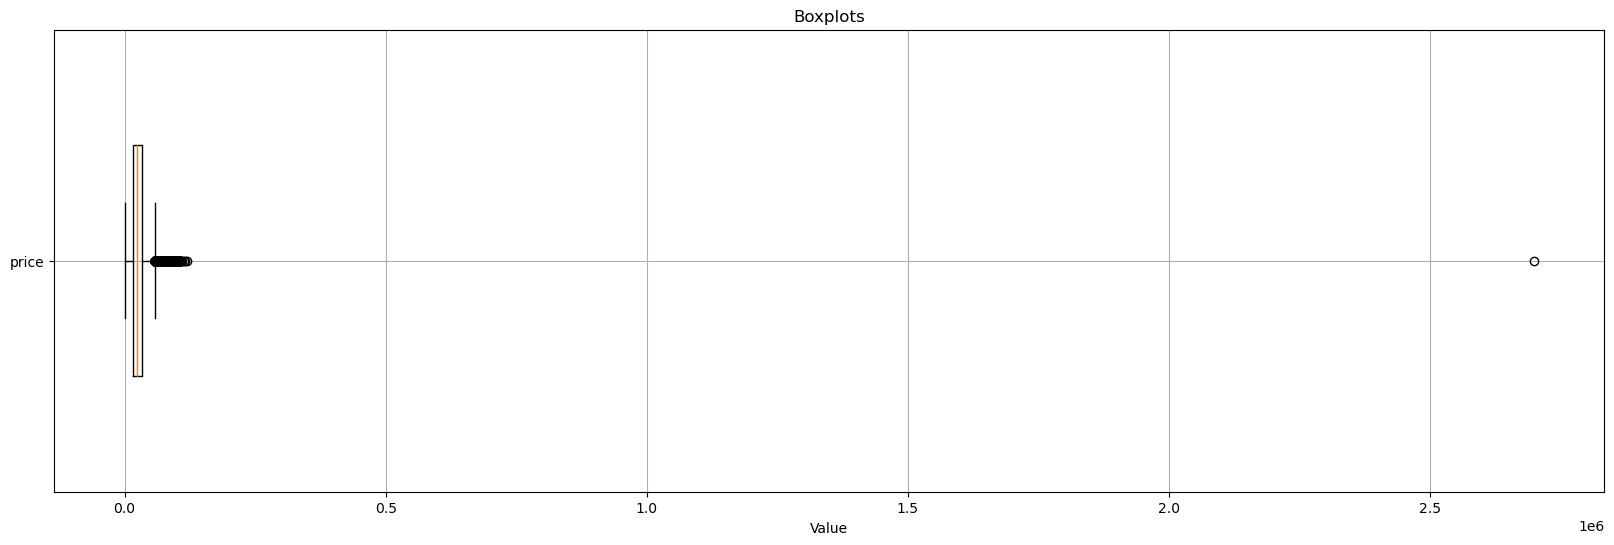

In [64]:
plot_boxplots(data=df, columns=["price"])

In [65]:
df.filter(col("price") > 60000).count()

9955

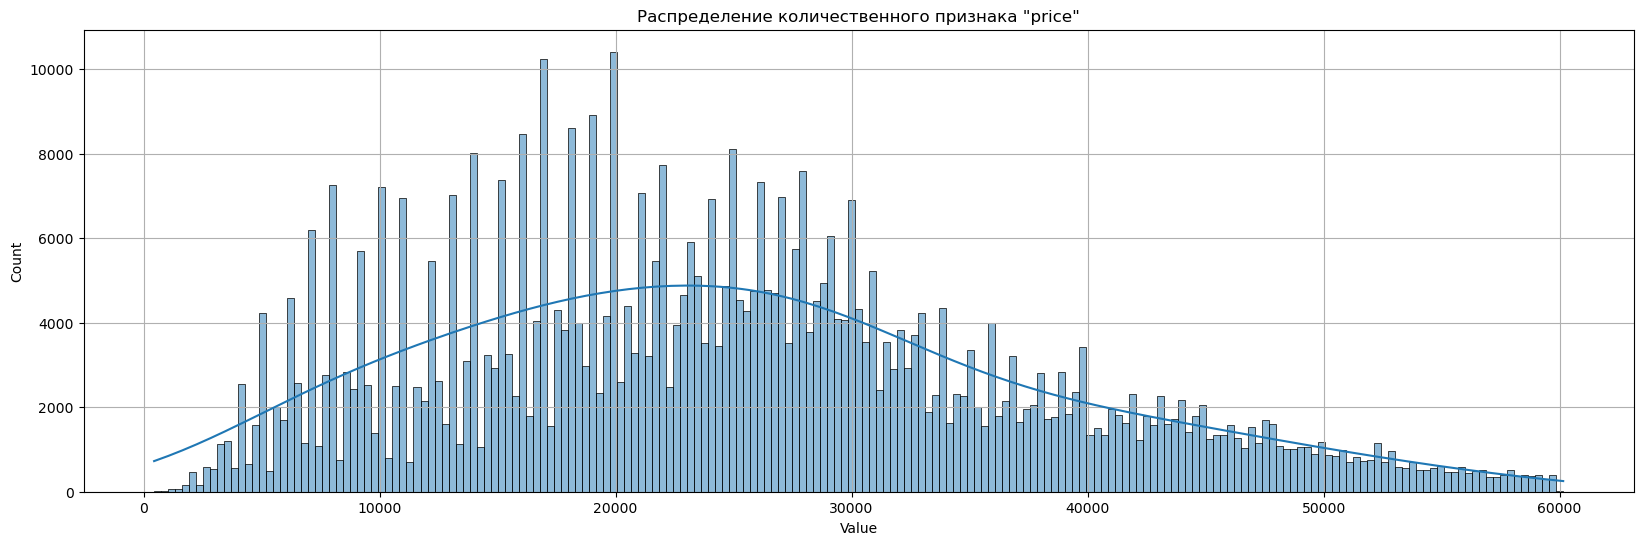

In [66]:
df = df.filter(col("price") <= 60000)
plot_quant_distribution(data=df, column="price")

In [67]:
df.show()

+-----------------+---------+------------+----------+---------------+-------+-------+------------+----+-----------+---------------------+----------------------+------------------+---------------------+-------------------------+
|              vin|body_type|daysonmarket|horsepower|maximum_seating|mileage|  price|wheel_system|year|is_any_cert|contains_Alloy Wheels|contains_Backup Camera|contains_Bluetooth|contains_Heated Seats|contains_Sunroof/Moonroof|
+-----------------+---------+------------+----------+---------------+-------+-------+------------+----+-----------+---------------------+----------------------+------------------+---------------------+-------------------------+
|0N0RDER1111111216|    Sedan|         7.0|     252.0|              5|   NULL|32465.0|         FWD|2020|      false|                false|                 false|             false|                false|                    false|
|19UDE2F30LA011015|    Sedan|         8.0|     201.0|              5|   11.0|26925.0|   

## Анализ столбца wheel_system

Признак категориальный.

In [68]:
count_nulls(data=df, column_name="wheel_system")

Число колонок с NULL: 275 (0.05%)


In [69]:
(
    df
    .filter(col("wheel_system").isNotNull())
    .groupBy("wheel_system")
    .count()
    .show()
)

+------------+------+
|wheel_system| count|
+------------+------+
|         4WD| 90470|
|         4X2|  5103|
|         FWD|208823|
|         AWD|216154|
|         RWD| 18937|
+------------+------+



Заменим пропуски модой.

In [70]:
wheel_system_mode = (
    df
    .filter(col("wheel_system").isNotNull())
    .groupBy("wheel_system")
    .count()
    .orderBy("count", ascending=False)
    .first()[0]
)
wheel_system_mode

'AWD'

In [71]:
df = df.fillna({"wheel_system": wheel_system_mode})

Количество категорий признака wheel_system: 5


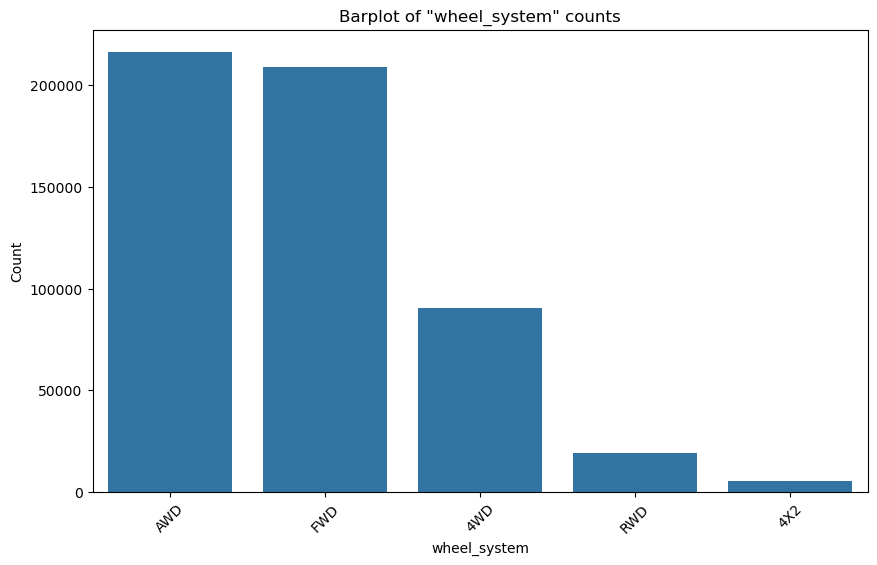

In [72]:
plot_cat_distribution(data=df, column_name="wheel_system")

In [73]:
df.show()

+-----------------+---------+------------+----------+---------------+-------+-------+------------+----+-----------+---------------------+----------------------+------------------+---------------------+-------------------------+
|              vin|body_type|daysonmarket|horsepower|maximum_seating|mileage|  price|wheel_system|year|is_any_cert|contains_Alloy Wheels|contains_Backup Camera|contains_Bluetooth|contains_Heated Seats|contains_Sunroof/Moonroof|
+-----------------+---------+------------+----------+---------------+-------+-------+------------+----+-----------+---------------------+----------------------+------------------+---------------------+-------------------------+
|0N0RDER1111111216|    Sedan|         7.0|     252.0|              5|   NULL|32465.0|         FWD|2020|      false|                false|                 false|             false|                false|                    false|
|19UDE2F30LA011015|    Sedan|         8.0|     201.0|              5|   11.0|26925.0|   

# Анализ столбца mileage

Признак количественный.

In [74]:
count_nulls(data=df, column_name="mileage")

Число колонок с NULL: 11561 (2.14%)


In [75]:
df = df.filter(col("mileage").isNotNull())
count_nulls(data=df, column_name="mileage")

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          0.00
Среднее значение:              37622.28
Среднеквадратичное отклонение: 49030.87
Первый квартиль:               5.00
Медиана:                       18662.00
Третий квартиль:               56999.00
Максимальное значение:         4290461.00


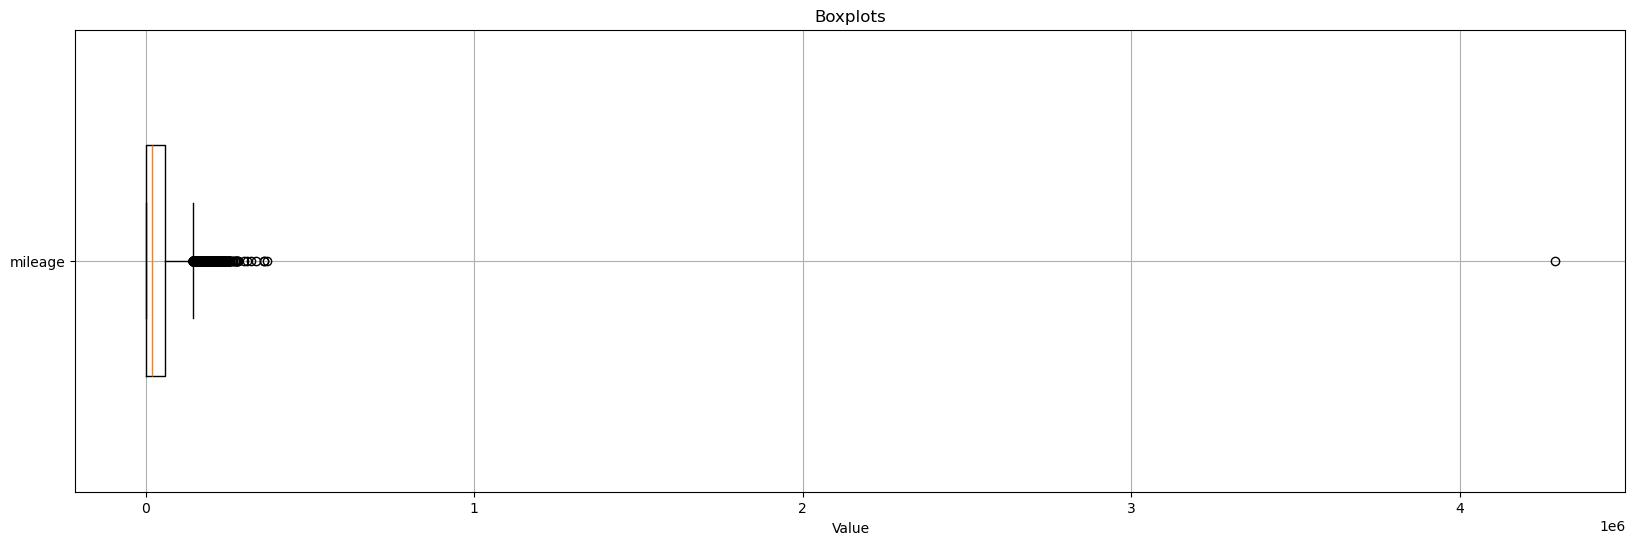

In [76]:
plot_boxplots(data=df, columns=["mileage"])

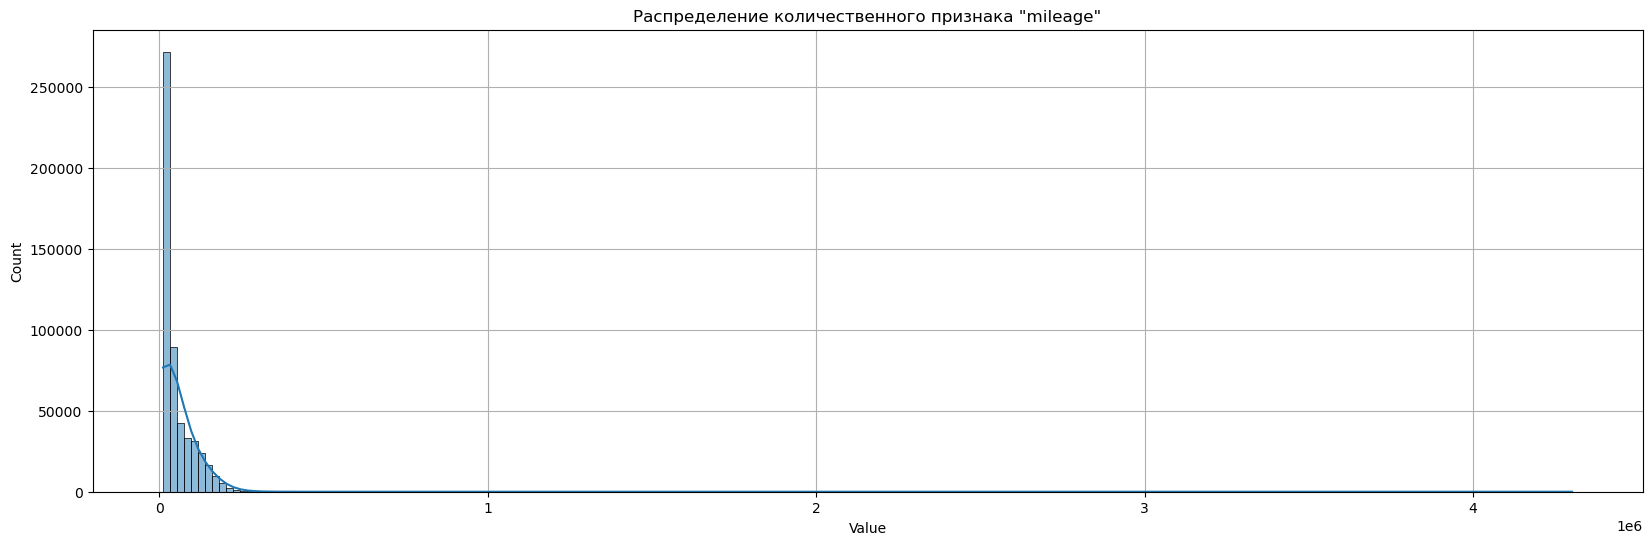

In [77]:
plot_quant_distribution(data=df, column="mileage")

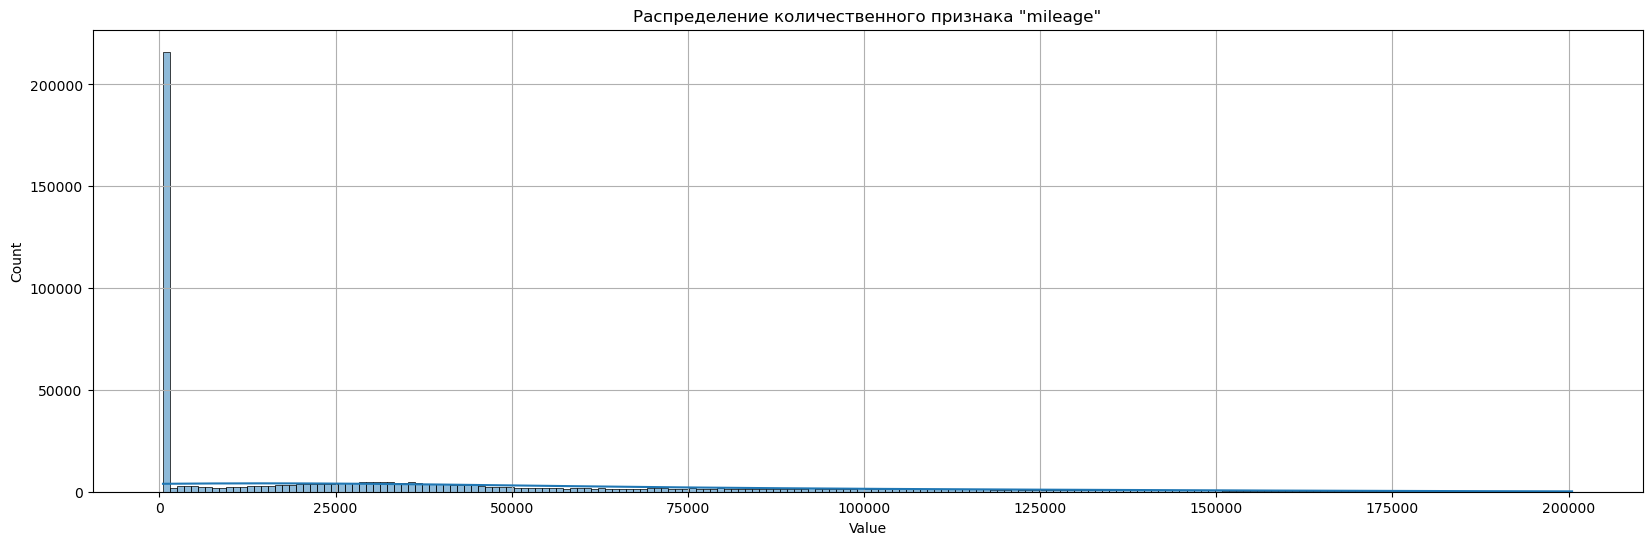

In [78]:
df = df.filter(col("mileage") <= 200000.0)
plot_quant_distribution(data=df, column="mileage")

In [79]:
df.show()

+-----------------+---------+------------+----------+---------------+-------+-------+------------+----+-----------+---------------------+----------------------+------------------+---------------------+-------------------------+
|              vin|body_type|daysonmarket|horsepower|maximum_seating|mileage|  price|wheel_system|year|is_any_cert|contains_Alloy Wheels|contains_Backup Camera|contains_Bluetooth|contains_Heated Seats|contains_Sunroof/Moonroof|
+-----------------+---------+------------+----------+---------------+-------+-------+------------+----+-----------+---------------------+----------------------+------------------+---------------------+-------------------------+
|19UDE2F30LA011015|    Sedan|         8.0|     201.0|              5|   11.0|26925.0|         FWD|2020|      false|                 true|                  true|             false|                 true|                     true|
|19UDE2F31HA005487|    Sedan|       302.0|     201.0|              5|39195.0|13900.0|   

## Анализ признака year

Признак количественный.

Преобразуем год выпуска в количество лет с года выпуска до 2024 года.

In [80]:
df = df.withColumn("age", lit(2025) - col("year")).drop("year")
df.show()

+-----------------+---------+------------+----------+---------------+-------+-------+------------+-----------+---------------------+----------------------+------------------+---------------------+-------------------------+---+
|              vin|body_type|daysonmarket|horsepower|maximum_seating|mileage|  price|wheel_system|is_any_cert|contains_Alloy Wheels|contains_Backup Camera|contains_Bluetooth|contains_Heated Seats|contains_Sunroof/Moonroof|age|
+-----------------+---------+------------+----------+---------------+-------+-------+------------+-----------+---------------------+----------------------+------------------+---------------------+-------------------------+---+
|19UDE2F30LA011015|    Sedan|         8.0|     201.0|              5|   11.0|26925.0|         FWD|      false|                 true|                  true|             false|                 true|                     true|  5|
|19UDE2F31HA005487|    Sedan|       302.0|     201.0|              5|39195.0|13900.0|       

## Расчет корреляции между количественными признаками

In [81]:
def compute_and_visualize_correlation_matrix(data: DataFrame, 
                                             columns: list[str]) -> None:
    """
    Вычисляет и визуализирует корреляционную матрицу для указанных 
    колонок в DataFrame PySpark.

    Args:
        df (DataFrame): DataFrame PySpark.
        columns (list[str]): Список колонок для вычисления корреляции.

    Returns:
        None
    """
    # Вычисление корреляционной матрицы
    corr_matrix = {}
    for col1 in columns:
        corr_matrix[col1] = {}
        for col2 in columns:
            corr_value = data.select(corr(col1, col2)).collect()[0][0]
            corr_matrix[col1][col2] = corr_value

    # Преобразование корреляционной матрицы в DataFrame Pandas для визуализации
    corr_matrix_pd = pd.DataFrame(corr_matrix)

    # Построение и визуализация корреляционной матрицы
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

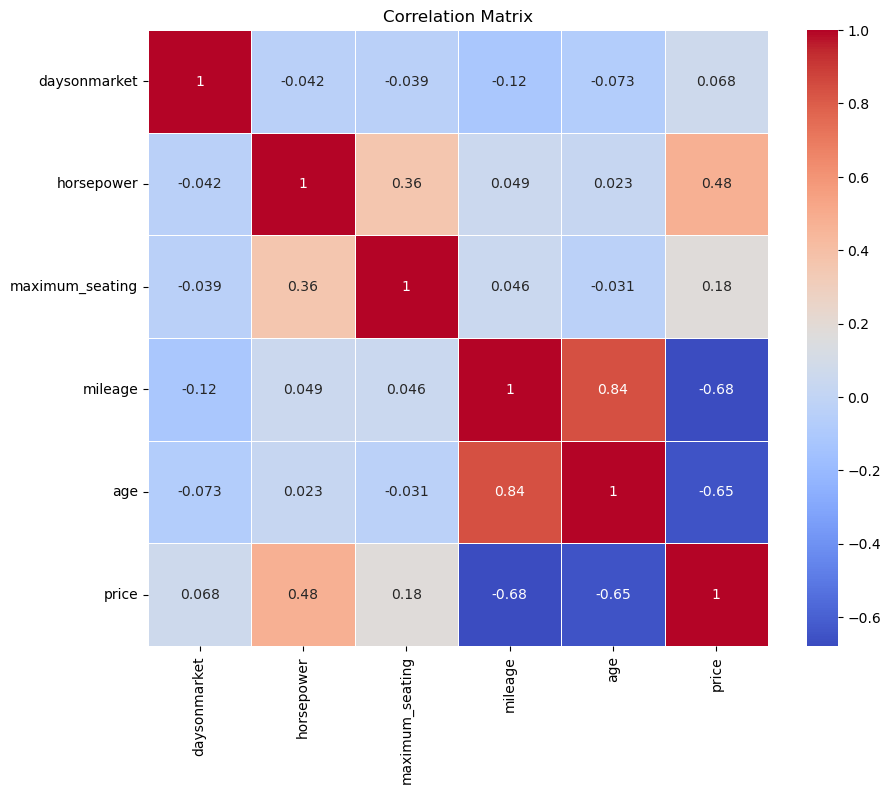

In [82]:
compute_and_visualize_correlation_matrix(
    data=df, columns=[
        "daysonmarket", "horsepower", "maximum_seating",
        "mileage", "age", "price"
    ]
)

Корреляционная матрица демонстрирует наличие корреляции между некоторыми количественными признаками.

In [83]:
df.show()

+-----------------+---------+------------+----------+---------------+-------+-------+------------+-----------+---------------------+----------------------+------------------+---------------------+-------------------------+---+
|              vin|body_type|daysonmarket|horsepower|maximum_seating|mileage|  price|wheel_system|is_any_cert|contains_Alloy Wheels|contains_Backup Camera|contains_Bluetooth|contains_Heated Seats|contains_Sunroof/Moonroof|age|
+-----------------+---------+------------+----------+---------------+-------+-------+------------+-----------+---------------------+----------------------+------------------+---------------------+-------------------------+---+
|19UDE2F30LA011015|    Sedan|         8.0|     201.0|              5|   11.0|26925.0|         FWD|      false|                 true|                  true|             false|                 true|                     true|  5|
|19UDE2F31HA005487|    Sedan|       302.0|     201.0|              5|39195.0|13900.0|       

Посмотрим, сколько объектов осталось после преобразований датасета.

In [84]:
df.count()

524646

In [85]:
df.printSchema()

root
 |-- vin: string (nullable = true)
 |-- body_type: string (nullable = false)
 |-- daysonmarket: double (nullable = true)
 |-- horsepower: float (nullable = false)
 |-- maximum_seating: integer (nullable = false)
 |-- mileage: float (nullable = true)
 |-- price: float (nullable = true)
 |-- wheel_system: string (nullable = false)
 |-- is_any_cert: boolean (nullable = false)
 |-- contains_Alloy Wheels: boolean (nullable = true)
 |-- contains_Backup Camera: boolean (nullable = true)
 |-- contains_Bluetooth: boolean (nullable = true)
 |-- contains_Heated Seats: boolean (nullable = true)
 |-- contains_Sunroof/Moonroof: boolean (nullable = true)
 |-- age: integer (nullable = true)



Сохраняем очищенную и обработанную таблицу на диск.

In [86]:
# Сохранение DataFrame в виде таблицы
df.writeTo("sobd_lab1_processed_table").using("iceberg").create()

In [87]:
for table in spark.catalog.listTables():
    print(table.name)

sobd_lab1_processed_table


Останавливаем Spark-сессию.

In [88]:
spark.stop()